In [24]:
!pip install PyPDF2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import spacy
import networkx as nx
from networkx.algorithms import bipartite
from collections import Counter
import PyPDF2
import matplotlib.pyplot as plt

In [25]:
# Open the PDF file
pdf_file = open(r"/content/Dibi.pdf", 'rb')
pdf_reader = PyPDF2.PdfReader(pdf_file)

In [15]:
# Extract text from the PDF file
text = ''
for page_num in range(len(pdf_reader.pages)):
    page_obj = pdf_reader.pages[page_num]
    text += page_obj.extract_text()

In [16]:
# Load the English language model in spaCy
nlp = spacy.load('en_core_web_sm')

In [17]:
# Parse the text using spaCy
doc = nlp(text)

In [18]:
# Extract named entities and create nodes in the knowledge graph
G = nx.Graph()
for entity in doc.ents:
    G.add_node(entity.text, type=entity.label_)

In [19]:
# Extract noun phrases and create edges between nodes in the knowledge graph
noun_chunks = list(doc.noun_chunks)
for chunk in noun_chunks:
    if len(chunk) > 1:
        nodes = [n for n in G.nodes() if chunk.text in n]
        for i in range(len(nodes)):
            for j in range(i+1, len(nodes)):
                G.add_edge(nodes[i], nodes[j], weight=1)

In [20]:
# Identify and remove isolated nodes in the knowledge graph
isolated_nodes = list(nx.isolates(G))
G.remove_nodes_from(isolated_nodes)

In [21]:
# Use bipartite projection to convert the knowledge graph into a simpler graph
B = bipartite.projected_graph(G, set(nx.get_node_attributes(G, 'type').keys()))

In [22]:
# Calculate node and edge weights based on node degree and edge weight, respectively
node_weights = Counter(dict(B.degree(weight='weight')))
edge_weights = Counter({(u, v): w for u, v, w in B.edges(data='weight') if w is not None})

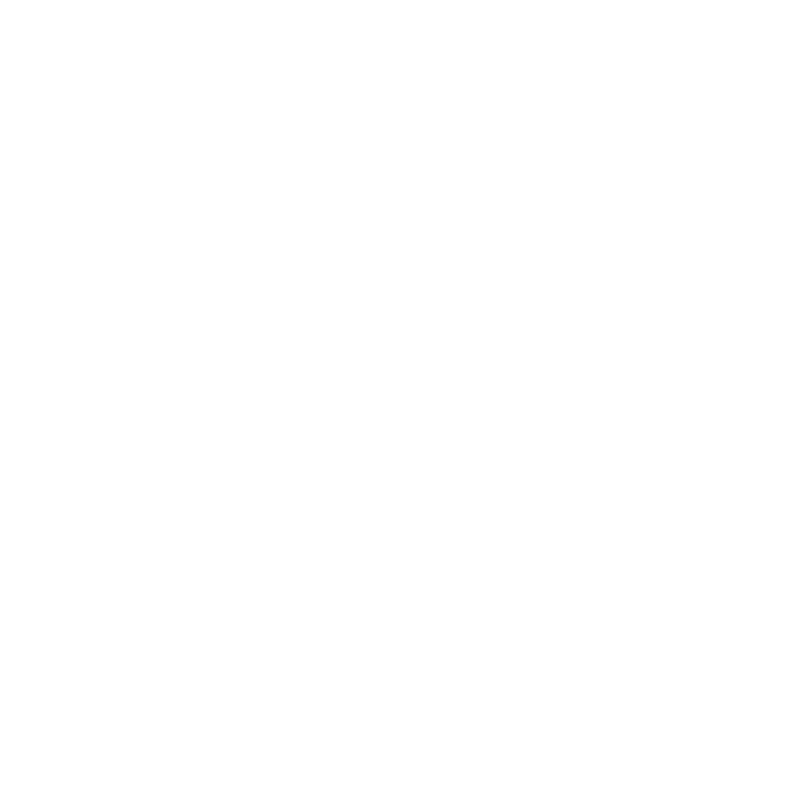

In [23]:
# Visualize the knowledge graph
pos = nx.spring_layout(B)
plt.figure(figsize=(10, 10))
nx.draw_networkx_nodes(B, pos, node_size=[v*100 for v in node_weights.values()], node_color='yellow')
nx.draw_networkx_labels(B, pos, font_size=8, font_weight='bold')
nx.draw_networkx_edges(B, pos, width=[w*3 for w in edge_weights.values()], edge_color='red')
plt.axis('off')
plt.show()